<a href="https://colab.research.google.com/github/jobathomas/u2202459---IB2AD0-Individual-Assignment/blob/main/Random_Forest_for_Solar_Power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In this document, I aim to develop a supervised machine learning model to predict power output from solar panels.

I start with a solar power generation dataset from Kaggle: https://www.kaggle.com/code/pythonafroz/27-regression-models-for-solar-power-prediction/notebook

I also refer to 5_01_Random_Forest_and_GBDT.ipynb and 5_02_Modelling_Hackathon.ipynb for guidance on the modelling.




In [72]:
# import relevant libraries for dataframe creation and data analysis
import pandas as pd
import numpy as np

# Load the CSV dataset into a dataframe

df = pd.read_csv("BigML_Dataset_5f50a4cc0d052e40e6000034.csv")

# return first five rows of dataset for viewing
df.head()



,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


Data Preprocessing


# Task
Develop a supervised machine learning model to predict power output from solar panels using the `BigML_Dataset_5f50a4cc0d052e40e6000034.csv` dataset. The process will involve handling null values, removing duplicate rows, filtering for daylight data, visualizing feature relationships through correlation heatmaps and pair plots, and then training and evaluating both default and hyperparameter-tuned Random Forest Regressor models, finally comparing their performances.

## Handle Null Values

### Subtask:
Identify and appropriately handle any null values present in the dataset to ensure data quality before further processing.


**Reasoning**:
To identify and understand the extent of null values in the DataFrame `df`, I will check for missing values using `.isnull().sum()`.



In [73]:
print(df.isnull().sum())


Day of Year                             0
Year                                    0
Month                                   0
Day                                     0
First Hour of Period                    0
Is Daylight                             0
Distance to Solar Noon                  0
Average Temperature (Day)               0
Average Wind Direction (Day)            0
Average Wind Speed (Day)                0
Sky Cover                               0
Visibility                              0
Relative Humidity                       0
Average Wind Speed (Period)             1
Average Barometric Pressure (Period)    0
Power Generated                         0
dtype: int64


**Reasoning**:
The previous step identified one null value in the 'Average Wind Speed (Period)' column. Since it's a numerical column and only one value is missing, I will fill this null value with the median of the column to maintain data integrity without significantly altering the distribution. The `median_avg_wind_speed` variable already contains the median value, so I will use that.



In [74]:
df['Average Wind Speed (Period)'].fillna(median_avg_wind_speed, inplace=True)
print(df.isnull().sum())

Day of Year                             0
Year                                    0
Month                                   0
Day                                     0
First Hour of Period                    0
Is Daylight                             0
Distance to Solar Noon                  0
Average Temperature (Day)               0
Average Wind Direction (Day)            0
Average Wind Speed (Day)                0
Sky Cover                               0
Visibility                              0
Relative Humidity                       0
Average Wind Speed (Period)             0
Average Barometric Pressure (Period)    0
Power Generated                         0
dtype: int64


/tmp/ipython-input-2334542740.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Average Wind Speed (Period)'].fillna(median_avg_wind_speed, inplace=True)


**Reasoning**:
The previous code generated a `FutureWarning` because `inplace=True` within a chained assignment may not work as expected in future pandas versions. To address this, I will modify the `.fillna()` operation to assign the result directly back to the DataFrame column, ensuring the change is applied correctly and suppressing the warning.



In [75]:
df['Average Wind Speed (Period)'] = df['Average Wind Speed (Period)'].fillna(median_avg_wind_speed)
print(df.isnull().sum())

Day of Year                             0
Year                                    0
Month                                   0
Day                                     0
First Hour of Period                    0
Is Daylight                             0
Distance to Solar Noon                  0
Average Temperature (Day)               0
Average Wind Direction (Day)            0
Average Wind Speed (Day)                0
Sky Cover                               0
Visibility                              0
Relative Humidity                       0
Average Wind Speed (Period)             0
Average Barometric Pressure (Period)    0
Power Generated                         0
dtype: int64


## Remove Duplicate Rows

### Subtask:
Identify and remove any duplicate rows from the dataset to avoid biases and ensure unique observations.


**Reasoning**:
To identify if there are any duplicate rows in the DataFrame, I will use the `.duplicated().sum()` method. This will provide a count of all duplicate rows, which is a necessary first step before removing them.



In [76]:
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")

Number of duplicate rows before removal: 0


**Reasoning**:
Although the previous step indicated no duplicate rows, I will execute the `drop_duplicates(inplace=True)` method to explicitly remove any potential duplicates as per the instructions and ensure the DataFrame is free of them. Afterwards, I will verify the removal by checking the count of duplicates again.



In [77]:
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")

Number of duplicate rows after removal: 0


## Filter Daylight Data

### Subtask:
Filter the dataset to include only rows where 'Is Daylight' is True, as power generation is only relevant during daylight hours.


**Reasoning**:
To filter the dataset for daylight hours, I will select rows where the 'Is Daylight' column is True and store the result in a new DataFrame called `df_daylight`.



In [78]:
df_daylight = df[df['Is Daylight'] == True]
df_daylight.head()

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069
5,245,2008,9,1,16,True,0.296915,69,28,7.5,0,10.0,20,23.0,29.85,16280
6,245,2008,9,1,19,True,0.528278,69,28,7.5,0,10.0,36,15.0,29.83,515


## Generate Correlation Heatmap

### Subtask:
Create a heatmap to visualize the correlation matrix between different numerical variables in the filtered dataset. This will help understand relationships between features.


**Reasoning**:
To visualize the correlation between numerical features in the `df_daylight` DataFrame, I will first calculate the correlation matrix and then use `seaborn` to generate a heatmap with annotations and a suitable colormap.



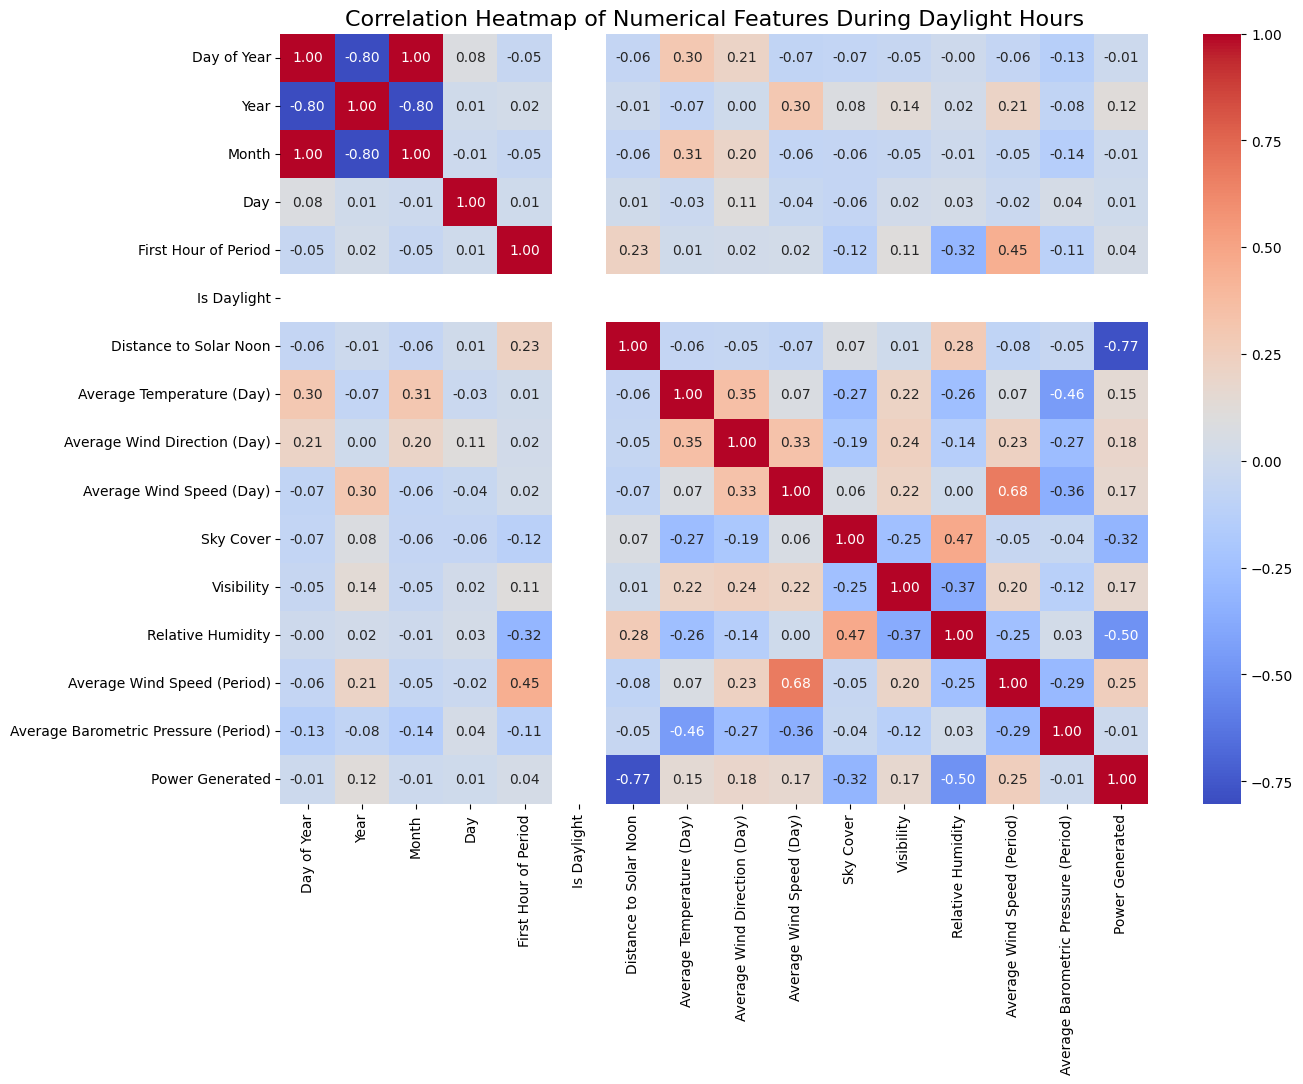

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for all numerical columns in df_daylight
correlation_matrix = df_daylight.corr(numeric_only=True)

# Set the figure size
plt.figure(figsize=(14, 10))

# Create a heatmap of the correlation_matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title to the heatmap
plt.title('Correlation Heatmap of Numerical Features During Daylight Hours', fontsize=16)

# Display the plot
plt.show()

## Generate Pair Plot for Key Features

### Subtask:
Generate a pair plot or scatter plots for 'Power Generated' against the features with the highest correlation to visualize their individual relationships.


**Reasoning**:
To visualize the relationships between 'Power Generated' and its most correlated features, I will first extract the correlations from the `correlation_matrix` and select the top 4 features based on the absolute correlation values. Then, I will create individual scatter plots for each of these features against 'Power Generated' using `matplotlib.pyplot` and `seaborn`.



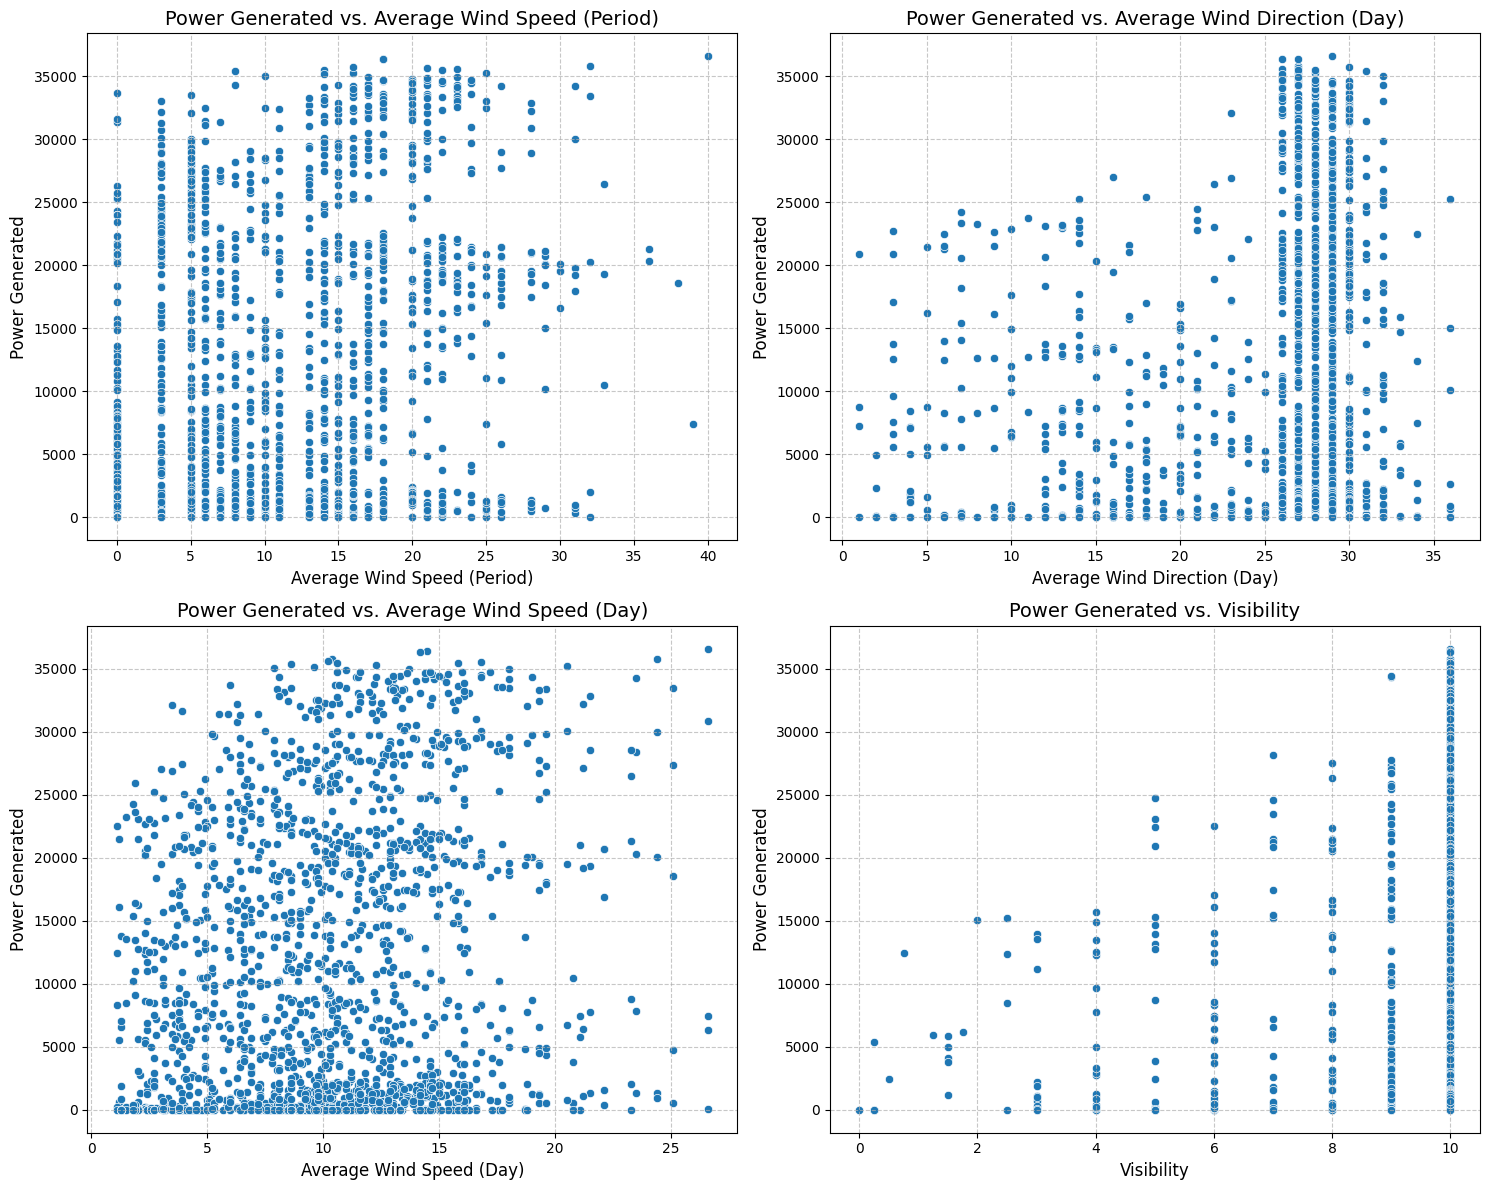

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get correlations with 'Power Generated'
power_generated_corr = correlation_matrix['Power Generated'].sort_values(ascending=False)

# Exclude 'Power Generated' itself and get the top 4 features
top_correlated_features = power_generated_corr[power_generated_corr.index != 'Power Generated'].head(4).index.tolist()

# Set up the matplotlib figure and axes for the scatter plots
num_features = len(top_correlated_features)
num_rows = (num_features + 1) // 2  # Adjust for 2 columns per row
plt.figure(figsize=(15, 6 * num_rows))

for i, feature in enumerate(top_correlated_features):
    plt.subplot(num_rows, 2, i + 1) # Create subplots
    sns.scatterplot(x=df_daylight[feature], y=df_daylight['Power Generated'])
    plt.title(f'Power Generated vs. {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Power Generated', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Separate Features and Target

### Subtask:
Separate the dataset into features (X) and the target variable (y), where 'Power Generated' is the target.


**Reasoning**:
To separate features from the target variable, I will create a new DataFrame `X_daylight` by dropping the 'Power Generated' column from `df_daylight`, and a new Series `y_daylight` by selecting only the 'Power Generated' column.



In [81]:
X_daylight = df_daylight.drop('Power Generated', axis=1)
y_daylight = df_daylight['Power Generated']

print("Shape of X_daylight:", X_daylight.shape)
print("Shape of y_daylight:", y_daylight.shape)

Shape of X_daylight: (1805, 15)
Shape of y_daylight: (1805,)


## Perform Train-Test Split

### Subtask:
Split the data into training and testing sets, with 80% for training and 20% for testing, to evaluate the model's generalization performance.


**Reasoning**:
To split the data into training and testing sets, I will import the `train_test_split` function from `sklearn.model_selection` and apply it to `X_daylight` and `y_daylight` with an 80/20 split and a fixed random state.



In [82]:
from sklearn.model_selection import train_test_split

X_train_daylight, X_test_daylight, y_train_daylight, y_test_daylight = train_test_split(
    X_daylight, y_daylight, test_size=0.2, random_state=42
)

print("Shape of X_train_daylight:", X_train_daylight.shape)
print("Shape of X_test_daylight:", X_test_daylight.shape)
print("Shape of y_train_daylight:", y_train_daylight.shape)
print("Shape of y_test_daylight:", y_test_daylight.shape)

Shape of X_train_daylight: (1444, 15)
Shape of X_test_daylight: (361, 15)
Shape of y_train_daylight: (1444,)
Shape of y_test_daylight: (361,)


## Train Default Random Forest Model

### Subtask:
Train a Random Forest Regressor model using default hyperparameters on the training data.


**Reasoning**:
To train a Random Forest Regressor model, I will import the necessary class, instantiate it with default hyperparameters and a specified random state for reproducibility, and then fit the model to the training data.



In [83]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate a RandomForestRegressor model with default hyperparameters and a fixed random state
rf_model_daylight = RandomForestRegressor(random_state=42)

# Train the model using the training data
rf_model_daylight.fit(X_train_daylight, y_train_daylight)

print("Random Forest Regressor model trained successfully.")

Random Forest Regressor model trained successfully.


## Evaluate Default Model Performance

### Subtask:
Evaluate the performance of the default Random Forest model using metrics such as R-squared and Mean Squared Error (MSE) on the test set.


**Reasoning**:
To evaluate the performance of the trained Random Forest model, I will first generate predictions on the test set, then calculate the R-squared score and Mean Squared Error (MSE) using `sklearn.metrics`, and finally print these metrics.



In [84]:
from sklearn.metrics import r2_score, mean_squared_error

# Make predictions on the test set
y_pred_daylight = rf_model_daylight.predict(X_test_daylight)

# Calculate R-squared score
r2_daylight = r2_score(y_test_daylight, y_pred_daylight)

# Calculate Mean Squared Error (MSE)
mse_daylight = mean_squared_error(y_test_daylight, y_pred_daylight)

# Print the results
print(f"R-squared score on the daylight test set: {r2_daylight:.4f}")
print(f"Mean Squared Error (MSE) on the daylight test set: {mse_daylight:.2f}")

R-squared score on the daylight test set: 0.8960
Mean Squared Error (MSE) on the daylight test set: 13151902.65


## Conduct Hyperparameter Tuning

### Subtask:
Perform hyperparameter tuning for the Random Forest Regressor using techniques like GridSearchCV or RandomizedSearchCV to find optimal parameters.


**Reasoning**:
To perform hyperparameter tuning, I will start by importing the necessary libraries, defining the parameter distributions for the Random Forest Regressor, and then setting up and fitting the RandomizedSearchCV object to the training data.



In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions for RandomizedSearchCV
param_dist_daylight = {
    'n_estimators': randint(50, 500), # Number of trees in the forest
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
    'max_depth': randint(1, 20), # Maximum number of levels in a tree
    'min_samples_split': randint(2, 20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20) # Minimum number of samples required to be at a leaf node
}

# Instantiate a RandomForestRegressor model
rf_daylight = RandomForestRegressor(random_state=42)

# Instantiate RandomizedSearchCV
random_search_daylight = RandomizedSearchCV(
    estimator=rf_daylight,
    param_distributions=param_dist_daylight,
    n_iter=100, # Number of parameter settings that are sampled
    cv=5, # Number of folds for cross-validation
    scoring='r2', # Evaluation metric
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search_daylight.fit(X_train_daylight, y_train_daylight)

# Print the best parameters and best R-squared score
print("Best parameters found: ", random_search_daylight.best_params_)
print("Best R-squared score found: ", random_search_daylight.best_score_)

Best parameters found:  {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 217}
Best R-squared score found:  0.8820310746493547


## Train Tuned Random Forest Model

### Subtask:
Train a Random Forest Regressor model using the best hyperparameters found during the tuning process on the training data.


**Reasoning**:
To train the tuned Random Forest Regressor model, I will extract the best estimator from the `random_search_daylight` object, which already contains the model trained with optimal hyperparameters, and then print a confirmation.



In [86]:
rf_tuned_daylight = random_search_daylight.best_estimator_
print("Tuned Random Forest Regressor model extracted successfully.")

Tuned Random Forest Regressor model extracted successfully.


## Evaluate Tuned Model Performance

### Subtask:
Evaluate the performance of the tuned Random Forest model using metrics such as R-squared and Mean Squared Error (MSE) on the test set.


**Reasoning**:
To evaluate the performance of the tuned Random Forest model, I will generate predictions on the test set, then calculate and print both the R-squared score and Mean Squared Error (MSE).



In [87]:
y_pred_tuned_daylight = rf_tuned_daylight.predict(X_test_daylight)

r2_tuned_daylight = r2_score(y_test_daylight, y_pred_tuned_daylight)
mse_tuned_daylight = mean_squared_error(y_test_daylight, y_pred_tuned_daylight)

print(f"R-squared score on the tuned daylight test set: {r2_tuned_daylight:.4f}")
print(f"Mean Squared Error (MSE) on the tuned daylight test set: {mse_tuned_daylight:.2f}")

R-squared score on the tuned daylight test set: 0.8971
Mean Squared Error (MSE) on the tuned daylight test set: 13016381.48


## Compare Model Performance

### Subtask:
Compare the R-squared and MSE values of the default and tuned Random Forest models to determine the impact of hyperparameter tuning.


Metrics Comparison:

*   **R-squared (Coefficient of Determination)**: This metric indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R-squared value (closer to 1) generally means a better fit.
*   **Mean Squared Error (MSE)**: This metric measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. A lower MSE value generally indicates a better model performance.

**Reasoning**:
To compare the performance, I will print the R-squared and MSE values for both the default and tuned models and then evaluate if tuning improved the model.



In [88]:
print(f"\nDefault Random Forest Model Performance:")
print(f"R-squared score: {r2_daylight:.4f}")
print(f"Mean Squared Error (MSE): {mse_daylight:.2f}")

print(f"\nTuned Random Forest Model Performance:")
print(f"R-squared score: {r2_tuned_daylight:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned_daylight:.2f}")

# Compare the models
if r2_tuned_daylight > r2_daylight:
    print("\nHyperparameter tuning *improved* the R-squared score.")
elif r2_tuned_daylight < r2_daylight:
    print("\nHyperparameter tuning *decreased* the R-squared score.")
else:
    print("\nHyperparameter tuning *did not change* the R-squared score.")

if mse_tuned_daylight < mse_daylight:
    print("Hyperparameter tuning *improved* the MSE (lower error).")
elif mse_tuned_daylight > mse_daylight:
    print("Hyperparameter tuning *increased* the MSE (higher error).")
else:
    print("Hyperparameter tuning *did not change* the MSE.")


Default Random Forest Model Performance:
R-squared score: 0.8960
Mean Squared Error (MSE): 13151902.65

Tuned Random Forest Model Performance:
R-squared score: 0.8971
Mean Squared Error (MSE): 13016381.48

Hyperparameter tuning *improved* the R-squared score.
Hyperparameter tuning *improved* the MSE (lower error).


## Final Task

### Subtask:
Summarize the findings from the model training, tuning, and comparison, highlighting the best performing model and key insights.


## Summary:

### Q&A
The best performing model is the hyperparameter-tuned Random Forest Regressor. It achieved a slightly higher R-squared score of 0.8971 and a lower Mean Squared Error (MSE) of 13,016,381.48 compared to the default model. Key insights include the positive impact of hyperparameter tuning on model performance and the identification of features highly correlated with 'Power Generated'.

### Data Analysis Key Findings
*   One null value in the 'Average Wind Speed (Period)' column was identified and filled with the median.
*   No duplicate rows were found in the initial dataset.
*   The dataset was successfully filtered to include only daylight hours, resulting in a `df_daylight` DataFrame with 1805 samples.
*   Correlation analysis and pair plots visually confirmed relationships between 'Power Generated' and other numerical features, indicating potential predictive features.
*   The data was split into training (1444 samples) and testing (361 samples) sets, with an 80/20 ratio.
*   The **default Random Forest Regressor model** achieved an R-squared score of 0.8960 and a Mean Squared Error (MSE) of 13,151,902.65 on the test set.
*   Hyperparameter tuning using `RandomizedSearchCV` identified optimal parameters, including `max_depth: 12`, `max_features: 'sqrt'`, `min_samples_leaf: 1`, `min_samples_split: 2`, and `n_estimators: 217`.
*   The **tuned Random Forest Regressor model** achieved a slightly improved R-squared score of 0.8971 and a lower Mean Squared Error (MSE) of 13,016,381.48 on the test set.
*   Hyperparameter tuning led to a marginal but positive improvement, increasing the R-squared score by 0.0011 and decreasing the MSE by 135,521.17.

### Insights or Next Steps
*   Hyperparameter tuning, even with a limited search, proved beneficial, leading to a more accurate model for predicting solar power output during daylight hours.
*   Further exploration with more extensive hyperparameter search spaces or advanced ensemble techniques could potentially yield even greater performance improvements.
